<a href="https://colab.research.google.com/github/cutemfc/Time_series_project/blob/main/Sarima_model_project_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sarima Analysis

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Based on the auto_arima: The optimal model is p=1, d=0 (no difference) and q (move avg)=1 The seasonal parameters are P=0(autoregression=0), D=1(seasonal difference) Q=2(seasonal lagvalue), m=7 is the weekly flunction

In [2]:
# Import google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# read the data from df_filled
df_filled=pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/df_filled.csv')
df_filled.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [5]:
df_train=df_filled.copy()
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [6]:
# Filter the data before 2014-04-01
max_date = '2014-04-01'
df_train = df_train[df_train['date'] < max_date]
df_train.head()
df_train.shape

(9437752, 6)

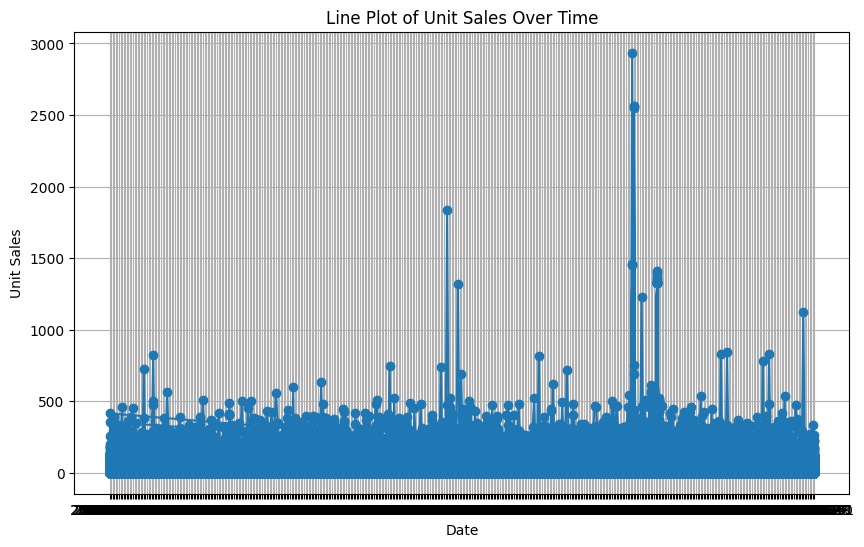

In [7]:
# Plot the line plot for df_train
plt.figure(figsize=(10, 6))
plt.plot(df_train['date'], df_train['unit_sales'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.title('Line Plot of Unit Sales Over Time')
plt.grid(True)
plt.show()

# Feature Engineering

In [8]:
# Time based Features
# Convert date Column to datetime
df_train['date']=pd.to_datetime(df_train['date'])
# Creating new time-based deatures
df_train['year']=df_train['date'].dt.year
df_train['month']=df_train['date'].dt.month
df_train['day']=df_train['date'].dt.day
df_train['day_of_week']=df_train['date'].dt.dayofweek
df_train['is_weekend']=df_train['day_of_week'].apply(lambda x: 1 if x>4 else 0)

In [13]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,is_weekend
0,24,105574,2013-01-02,18790.0,12.0,0.0,2013,1,2,2,0
1,24,105574,2013-01-03,59692.0,1.0,0.0,2013,1,3,3,0
2,24,105574,2013-01-04,99664.0,3.0,0.0,2013,1,4,4,0
3,24,105574,2013-01-05,140805.0,4.0,0.0,2013,1,5,5,1
4,24,105574,2013-01-06,182800.0,7.0,0.0,2013,1,6,6,1


# Split the data into training and testing parts

In [8]:
# check the missing values
df_train.isnull().sum()

,0
store_nbr,0
item_nbr,0
date,0
id,6690477
unit_sales,0
onpromotion,6690477


In [9]:
# check duplicate date
duplicates = df_train[df_train.duplicated(subset=['date'], keep=False)]
print(duplicates)
duplicates.shape

          store_nbr  item_nbr        date        id  unit_sales  onpromotion
0                24    105574  2013-01-02   18790.0        12.0          0.0
1                24    105574  2013-01-03   59692.0         1.0          0.0
2                24    105574  2013-01-04   99664.0         3.0          0.0
3                24    105574  2013-01-05  140805.0         4.0          0.0
4                24    105574  2013-01-06  182800.0         7.0          0.0
...             ...       ...         ...       ...         ...          ...
35068118         51   2123791  2014-03-27       NaN         0.0          NaN
35068119         51   2123791  2014-03-28       NaN         0.0          NaN
35068120         51   2123791  2014-03-29       NaN         0.0          NaN
35068121         51   2123791  2014-03-30       NaN         0.0          NaN
35068122         51   2123791  2014-03-31       NaN         0.0          NaN

[9437752 rows x 6 columns]


(9437752, 6)

In [10]:
# Groupby by 'date' and aggregate 'unit_sales' by sum
df_train = df_train.groupby('date')['unit_sales'].sum().reset_index()

In [11]:
df_train.head()

,date,unit_sales
0,2013-01-02,42320.0
1,2013-01-03,32708.0
2,2013-01-04,30849.0
3,2013-01-05,42351.0
4,2013-01-06,43988.0


In [12]:
# To create time series features again
df_train['date']=pd.to_datetime(df_train['date'])# ensure the date is the datetime
df_train['month']=df_train['date'].dt.month
df_train['year']=df_train['date'].dt.year
df_train['day']=df_train['date'].dt.day
df_train['dayofweek']=df_train['date'].dt.dayofweek+1 #monday is 1 and sunday is 7
df_train['is_weekend']=df_train['dayofweek'].apply(lambda x: 1 if x>5 else 2)
df_train.set_index('date',inplace=True)

In [91]:
df_train.head()

,unit_sales,month,year,day,dayofweek,is_weekend,log_unit_sales
date,,,,,,,
2013-01-02,42320.0,1,2013,2,2.0,NaN,10.653039
2013-01-03,32708.0,1,2013,3,3.0,NaN,10.395406
2013-01-04,30849.0,1,2013,4,4.0,NaN,10.336892
2013-01-05,42351.0,1,2013,5,5.0,1.0,10.653771
2013-01-06,43988.0,1,2013,6,6.0,1.0,10.691695


In [13]:
df_train.isnull().sum()


,0
unit_sales,0
month,0
year,0
day,0
dayofweek,0
is_weekend,0


In [86]:
df_train[df_train <0]

,unit_sales,month,year,day,dayofweek,is_weekend,log_unit_sales
date,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2014-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Remove df_train<0
df_train=df_train[df_train>0]

In [74]:
df_train.shape

(453, 7)

In [15]:
# Remove df_train <0
df_train=df_train[df_train['unit_sales']>0]

In [25]:
df_train[df_train['is_weekend']<0]

,unit_sales,month,year,day,dayofweek,is_weekend
date,,,,,,


In [82]:
df_train.shape

(453, 7)

In [29]:
df_train.shape

(453, 6)

In [30]:
len(df_train)

453

# Split the data into train and test parts

In [85]:
# Split the data to 0.8 for train size and 0.2 for test size
train_size= int(len(df_train)*0.8)
train, test=df_train[:train_size],df_train[train_size:]


In [32]:
test.shape

(91, 6)

In [33]:
train.shape

(362, 6)

In [34]:
test.head()

,unit_sales,month,year,day,dayofweek,is_weekend
date,,,,,,
2013-12-31,58694.000,12,2013,31,1,0
2014-01-01,2005.868,1,2014,1,2,0
2014-01-02,61947.875,1,2014,2,3,0
2014-01-03,54187.897,1,2014,3,4,0
2014-01-04,71364.655,1,2014,4,5,1


In [ ]:
test.shape

(28, 6)

In [79]:
train.isnull().sum()

,0
unit_sales,0
month,0
year,0
day,0
dayofweek,52
is_weekend,258
log_unit_sales,0


In [93]:
train['dayofweek'].unique()

array([ 2.,  3.,  4.,  5.,  6., nan,  1.])

In [81]:
train['is_weekend'].unique()

array([nan,  1.])

# Modeling by SARIMA

Based on the auto_arima: The optimal model is p=1, d=0 (no difference) and q (move avg)=1 The seasonal parameters are P=0(autoregression=0), D=1(seasonal difference) Q=2(seasonal lagvalue), m=7 is the weekly flunction

In [54]:
# Modeling with SARIMA
# Initialize and train the SARIMA　model with seasonal order(P,D,Q,m),
sarimax_model = SARIMAX(train['unit_sales'], order=(1,0,1),seasonal_order=(0,1,2,7),exog=train['dayofweek'])# weekly is 7, try to find the extra factor change of month(e.g.Christmas in December)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [55]:
# Fit the model
sarimax_model_fit= sarimax_model.fit()

In [56]:
# Forcast the model, use the get_forcast combined with index to make sure the time period correct
forecast=sarimax_model_fit.get_forecast(len(test),exog=test[['dayofweek']])
forecast_mean=forecast.predicted_mean
forecast_mean.index=test.index

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


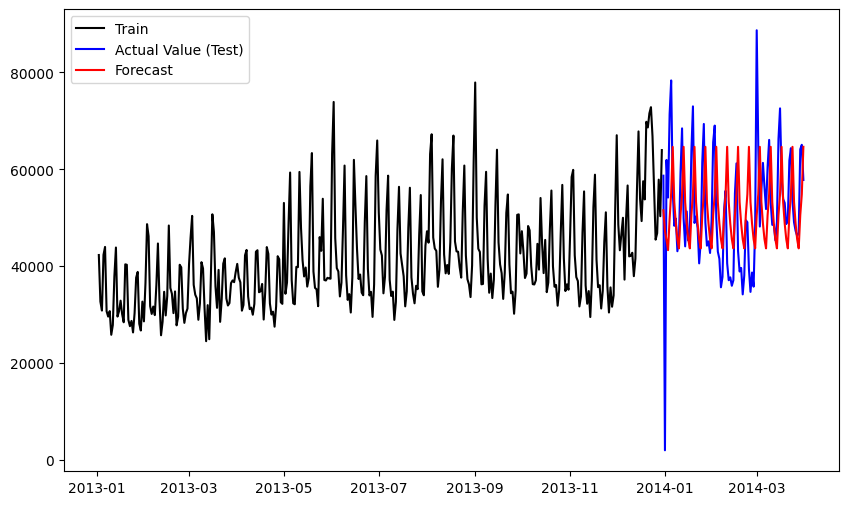

In [58]:
# Visualization of the predict values
plt.figure(figsize=(10,6))
plt.plot(train['unit_sales'],label='Train', color='black')
plt.plot(test['unit_sales'],label='Actual Value (Test)',color='blue')
plt.plot(test.index, forecast_mean, label='Forecast',color='red')
plt.legend()
plt.show()

# There is great drop down in the period of 2014-01

# Evaluate the model

In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error

In [61]:
# Evalute the sarima model
mae=mean_absolute_error(test['unit_sales'],forecast_mean)
r2=r2_score(test['unit_sales'],forecast_mean)
mse=mean_squared_error(test['unit_sales'],forecast_mean)
mape=mean_absolute_percentage_error(test['unit_sales'],forecast_mean)*100

print(f'R2 score {np.round(r2,2)}\nMean absolute error {np.round(mae,2)}')
print(f'Mean squared error {np.round(mse,2)}\nMean absolute percentage error {np.round(mape,2)}')




R2 score -0.05
Mean absolute error 9642.84
Mean squared error 152529300.68
Mean absolute percentage error 42.58


In [ ]:
# If we exog is is_weekend
# Initialize and train the SARIMA　model with seasonal order(P,D,Q,m)
sarimax_model = SARIMAX(train['unit_sales'], order=(1,0,1),seasonal_order=(0,1,2,7),exog=train['is_weekend'])# weekly is 7, try to find the change of month(Christ in December)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [62]:
# try to use p=5, d=1, 0
sarimax_model = SARIMAX(train['unit_sales'], order=(5,1,0),seasonal_order=(0,1,2,7),exog=train['dayofweek'])#
sarimax_model_fit= sarimax_model.fit()
forecast=sarimax_model_fit.get_forecast(len(test),exog=test[['dayofweek']])
forecast_mean=forecast.predicted_mean
forecast_mean.index=test.index


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [63]:
# Evalute the sarima model
mae=mean_absolute_error(test['unit_sales'],forecast_mean)
r2=r2_score(test['unit_sales'],forecast_mean)
mse=mean_squared_error(test['unit_sales'],forecast_mean)
mape=mean_absolute_percentage_error(test['unit_sales'],forecast_mean)*100

print(f'R2 score {np.round(r2,2)}\nMean absolute error {np.round(mae,2)}')
print(f'Mean squared error {np.round(mse,2)}\nMean absolute percentage error {np.round(mape,2)}')



R2 score -0.63
Mean absolute error 12337.92
Mean squared error 235289016.06
Mean absolute percentage error 44.0


It become worse.We try to use is_weekend as exog

In [64]:
sarimax_model = SARIMAX(train['unit_sales'], order=(1,0,1),seasonal_order=(0,1,2,7),exog=train['is_weekend'])#
sarimax_model_fit= sarimax_model.fit()
forecast=sarimax_model_fit.get_forecast(len(test),exog=test[['is_weekend']])
forecast_mean=forecast.predicted_mean
forecast_mean.index=test.index

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [65]:
# Evalute the sarima model
mae=mean_absolute_error(test['unit_sales'],forecast_mean)
r2=r2_score(test['unit_sales'],forecast_mean)
mse=mean_squared_error(test['unit_sales'],forecast_mean)
mape=mean_absolute_percentage_error(test['unit_sales'],forecast_mean)*100

print(f'R2 score {np.round(r2,2)}\nMean absolute error {np.round(mae,2)}')
print(f'Mean squared error {np.round(mse,2)}\nMean absolute percentage error {np.round(mape,2)}')


R2 score -0.13
Mean absolute error 9994.83
Mean squared error 163076543.02
Mean absolute percentage error 43.05


It become worse.

In [16]:
# We try to log to reduce the fluctation of the unit_sales
df_train['log_unit_sales']=np.log1p(df_train['unit_sales']) # log(1+x) avoid log(0)
#
df_train.head()

,unit_sales,month,year,day,dayofweek,is_weekend,log_unit_sales
date,,,,,,,
2013-01-02,42320.0,1,2013,2,3,2,10.653039
2013-01-03,32708.0,1,2013,3,4,2,10.395406
2013-01-04,30849.0,1,2013,4,5,2,10.336892
2013-01-05,42351.0,1,2013,5,6,1,10.653771
2013-01-06,43988.0,1,2013,6,7,1,10.691695


In [17]:
df_train[df_train['log_unit_sales']<0]

,unit_sales,month,year,day,dayofweek,is_weekend,log_unit_sales
date,,,,,,,


In [18]:
## If we exog is dayofweek
# Initialize and train the SARIMA　model with seasonal order(P,D,Q,m)
train_size= int(len(df_train)*0.8)
train, test=df_train[:train_size],df_train[train_size:]
sarimax_model_log = SARIMAX(train['log_unit_sales'], order=(1,0,1),seasonal_order=(0,1,2,7),exog=train['dayofweek'])# weekly is 7, try to find the change of month(Christ in December)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
sarimax_model_log_fit= sarimax_model_log.fit()
forecast=sarimax_model_log_fit.get_forecast(len(test),exog=test[['is_weekend']])
forecast_mean=forecast.predicted_mean
forecast_mean.index=test.index

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [84]:
train.isnull().sum()

,0
unit_sales,0
month,0
year,0
day,0
dayofweek,52
is_weekend,258
log_unit_sales,0


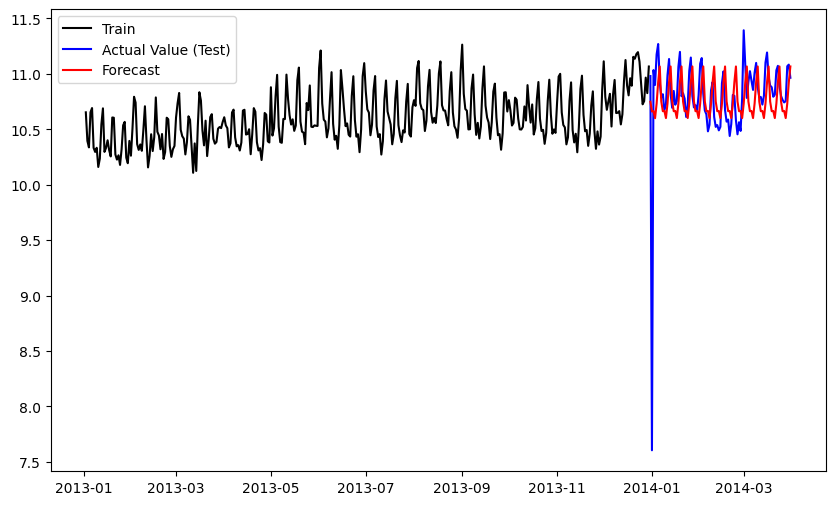

In [20]:
# Visualization of the predict values
plt.figure(figsize=(10,6))
plt.plot(train['log_unit_sales'],label='Train', color='black')
plt.plot(test['log_unit_sales'],label='Actual Value (Test)',color='blue')
plt.plot(test.index, forecast_mean, label='Forecast',color='red')
plt.legend()
plt.show()

In [23]:
# Evalute the sarima model
mae=mean_absolute_error(test['log_unit_sales'],forecast_mean)
r2=r2_score(test['log_unit_sales'],forecast_mean)
mse=mean_squared_error(test['log_unit_sales'],forecast_mean)
mape=mean_absolute_percentage_error(test['log_unit_sales'],forecast_mean)*100

print(f'R2 score {np.round(r2,2)}\nMean absolute error {np.round(mae,2)}')
print(f'Mean squared error {np.round(mse,2)}\nMean absolute percentage error {np.round(mape,2)}')

R2 score 0.02
Mean absolute error 0.22
Mean squared error 0.15
Mean absolute percentage error 2.15


After log the unit sales, the model become better

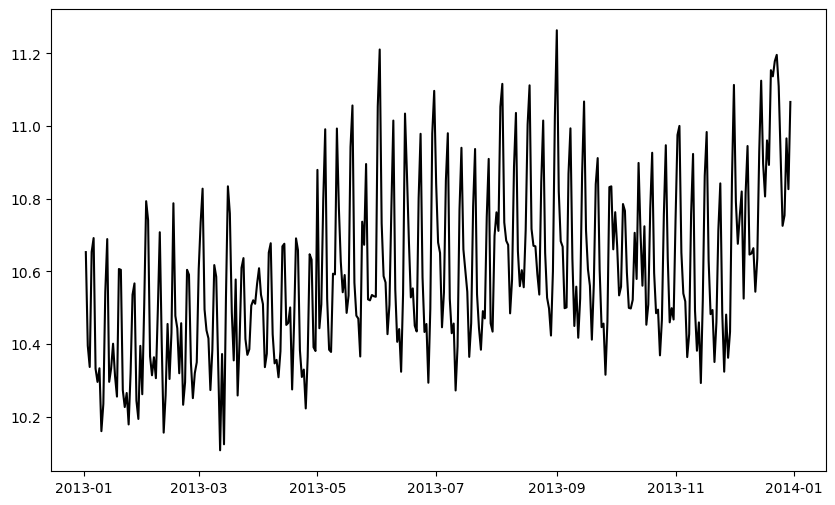

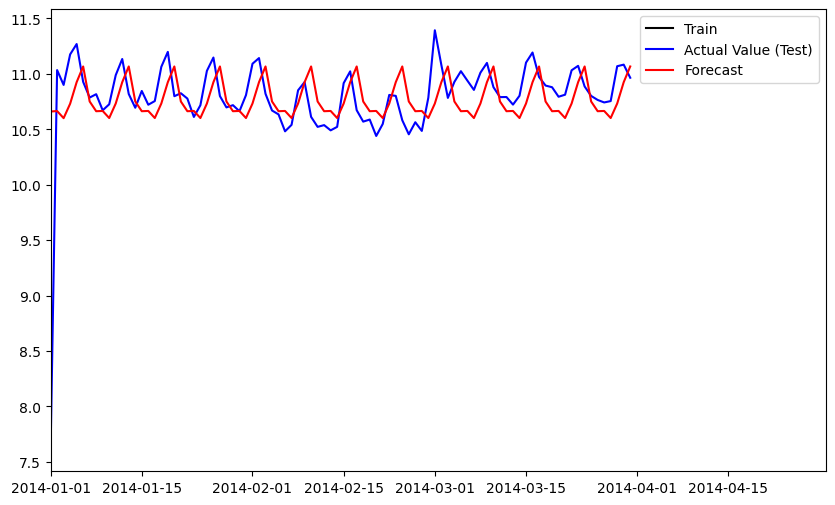

In [26]:
# Visualization of the predict values, enlarge the 2014-01 to 2014-04
plt.figure(figsize=(10,6))
plt.plot(train['log_unit_sales'],label='Train', color='black')
# Visualization of the predict values, enlarge the 2014-01 to 2014-04
plt.figure(figsize=(10,6))
plt.plot(train['log_unit_sales'],label='Train', color='black')
plt.plot(test['log_unit_sales'],label='Actual Value (Test)',color='blue')
plt.plot(test.index, forecast_mean, label='Forecast',color='red')
plt.xlim([pd.to_datetime('2014-01-01'),pd.to_datetime('2014-04-30')])
plt.legend()
plt.show()

# The forcast is with the right schift, try to adjsut the parameter of d=1

In [27]:
## If we exog is dayofweek, and order=1, 1, 1
# Initialize and train the SARIMA　model with seasonal order(P,D,Q,m)
train_size= int(len(df_train)*0.8)
train, test=df_train[:train_size],df_train[train_size:]
sarimax_model_log = SARIMAX(train['log_unit_sales'], order=(1,1,1),seasonal_order=(0,1,2,7),exog=train['dayofweek'])# weekly is 7, try to find the change of month(Christ in December)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [28]:
sarimax_model_log_fit= sarimax_model_log.fit()
forecast=sarimax_model_log_fit.get_forecast(len(test),exog=test[['is_weekend']])
forecast_mean=forecast.predicted_mean
forecast_mean.index=test.index

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


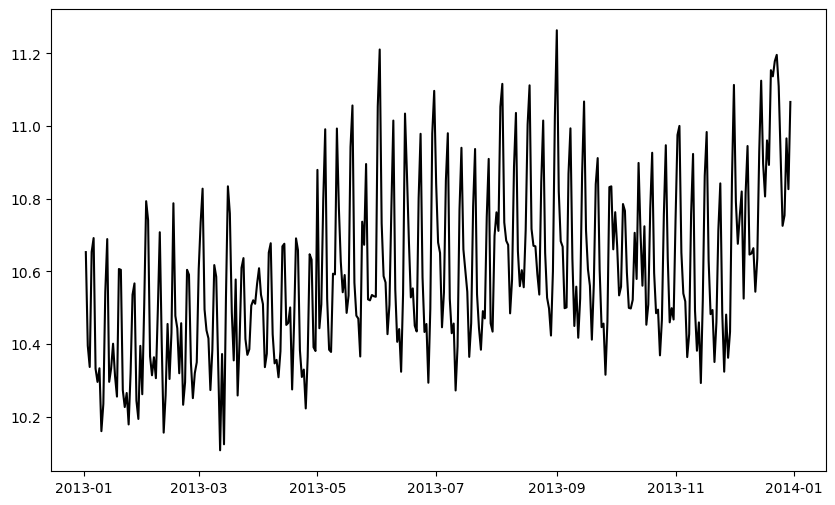

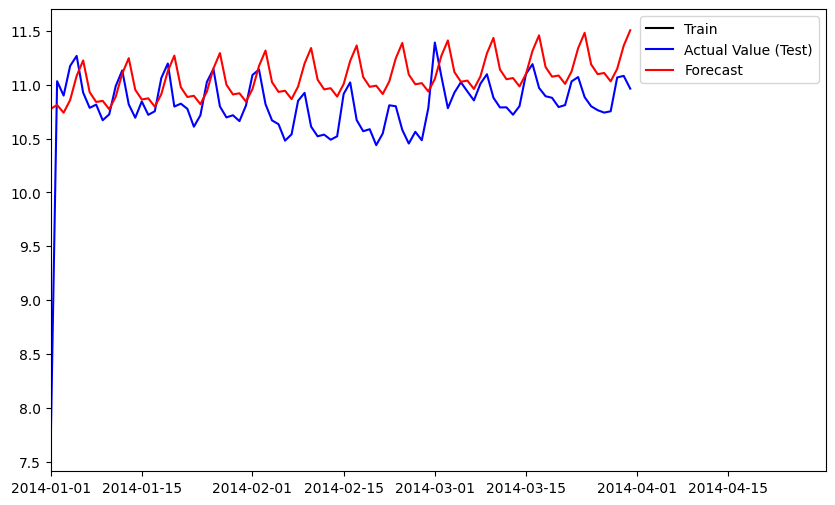

In [29]:
# Visualization of the predict values, enlarge the 2014-01 to 2014-04
plt.figure(figsize=(10,6))
plt.plot(train['log_unit_sales'],label='Train', color='black')
# Visualization of the predict values, enlarge the 2014-01 to 2014-04
plt.figure(figsize=(10,6))
plt.plot(train['log_unit_sales'],label='Train', color='black')
plt.plot(test['log_unit_sales'],label='Actual Value (Test)',color='blue')
plt.plot(test.index, forecast_mean, label='Forecast',color='red')
plt.xlim([pd.to_datetime('2014-01-01'),pd.to_datetime('2014-04-30')])
plt.legend()
plt.show()

In [30]:
# Evalute the sarima model
mae=mean_absolute_error(test['log_unit_sales'],forecast_mean)
r2=r2_score(test['log_unit_sales'],forecast_mean)
mse=mean_squared_error(test['log_unit_sales'],forecast_mean)
mape=mean_absolute_percentage_error(test['log_unit_sales'],forecast_mean)*100

print(f'R2 score {np.round(r2,2)}\nMean absolute error {np.round(mae,2)}')
print(f'Mean squared error {np.round(mse,2)}\nMean absolute percentage error {np.round(mape,2)}')

R2 score -0.42
Mean absolute error 0.31
Mean squared error 0.22
Mean absolute percentage error 3.0


The optical model is oder is 1 0, 1 and percent absolute error is 2.15% for the sarima model